In [175]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
from urllib.parse import quote
import datetime
import seaborn as sns
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt

import statsmodels.api as sm
from pylab import rcParams

import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['grid.linestyle'] = ':'   
plt.rcParams['axes.grid'] = True

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.color_palette("RdBu", n_colors=10)

# %matplotlib inline
# %config InlineBackend.figure_formats = {'png', 'retina'}

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet


print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version', sns.__version__)

Numpy version 1.26.4
Pandas version 2.2.2
Seaborn version 0.13.2


In [176]:
def get_forecast_accuracy(y, y_hat):
    # ME
    me = (y - y_hat).sum()/len(y)

    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_hat))

    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat) * 100
    
    # WAPE
    wape = (y - y_hat).__abs__().sum() / y.__abs__().sum() * 100

    print("ME: %.2f, RMSE: %.2f, MAPE: %.2f%%, WAPE: %.2f%%" % (me,rmse,mape,wape))

In [177]:
cur_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("current times:", cur_time)

current times: 2024-07-30 01:26:19


In [179]:
case = pd.read_csv("../r506_pipeline/data/df2.csv", encoding="cp874" )
temp = pd.read_csv("../temp_pipeline/data/dataset/temp.csv", encoding="cp874")
rain = pd.read_csv("../rain_pipeline/data/dataset/rain.csv", encoding="cp874")
press = pd.read_csv("../pressure_pipeline/data/dataset/press.csv", encoding="cp874")
humidity = pd.read_csv("../humidity_pipeline/data/dataset/humidity.csv", encoding="cp874")

In [180]:
case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        232 non-null    object
 1   total_case  232 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


In [9]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    312 non-null    object 
 1   temp    312 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [181]:
df = case.merge(temp,on='date',how='left')
df = df.merge(press,on='date',how='left')
df = df.merge(humidity,on='date',how='left')
df = df.merge(rain,on='date',how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        232 non-null    object 
 1   total_case  232 non-null    int64  
 2   temp        232 non-null    float64
 3   press       224 non-null    float64
 4   humidity    232 non-null    float64
 5   rain        232 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.0+ KB


In [182]:
# Create pandas time series with date labels correctly shown. 
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
#df['rolling_weekly_avg'] = df.new_cases.rolling(window=7).mean().fillna(0)

# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':df.index,'y':df.total_case})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts.describe()

,ds,y
count,232,232.000000
mean,2021-07-10 09:43:26.896551680,22.500000
min,2019-01-07 00:00:00,1.000000
25%,2020-02-16 06:00:00,4.000000
50%,2021-06-23 00:00:00,19.000000
75%,2022-11-18 18:00:00,32.000000
max,2023-12-29 00:00:00,104.000000
std,NaN,20.103843


In [183]:
ts.tail(2)
ts.info()

,ds,y
date,,
2023-12-22,2023-12-22,11
2023-12-29,2023-12-29,22


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2019-01-07 to 2023-12-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      232 non-null    datetime64[ns]
 1   y       232 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.4 KB


<Axes: xlabel='date'>

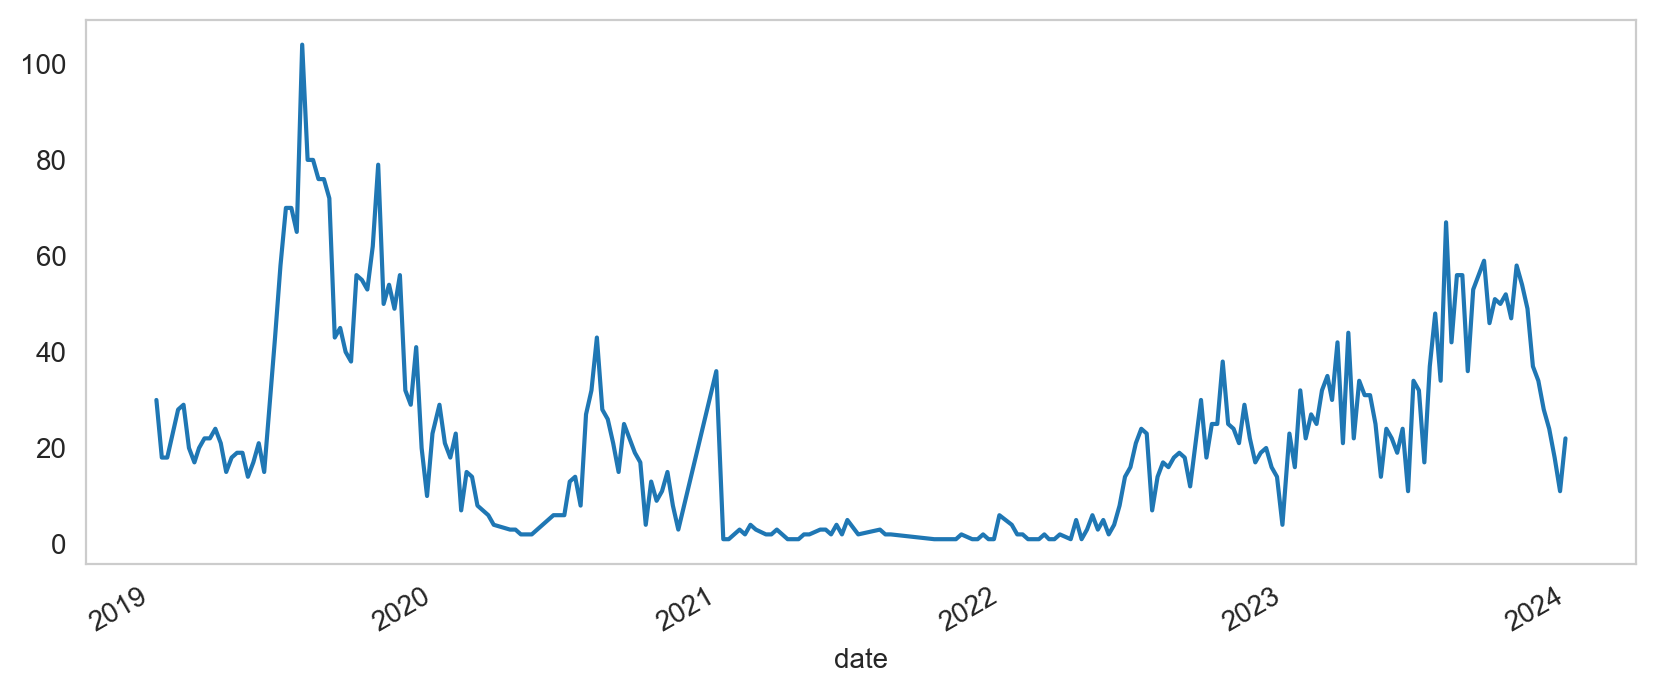

In [184]:
ts['y'].plot(figsize=(10,4))

01:29:02 - cmdstanpy - INFO - Chain [1] start processing
01:29:02 - cmdstanpy - INFO - Chain [1] done processing


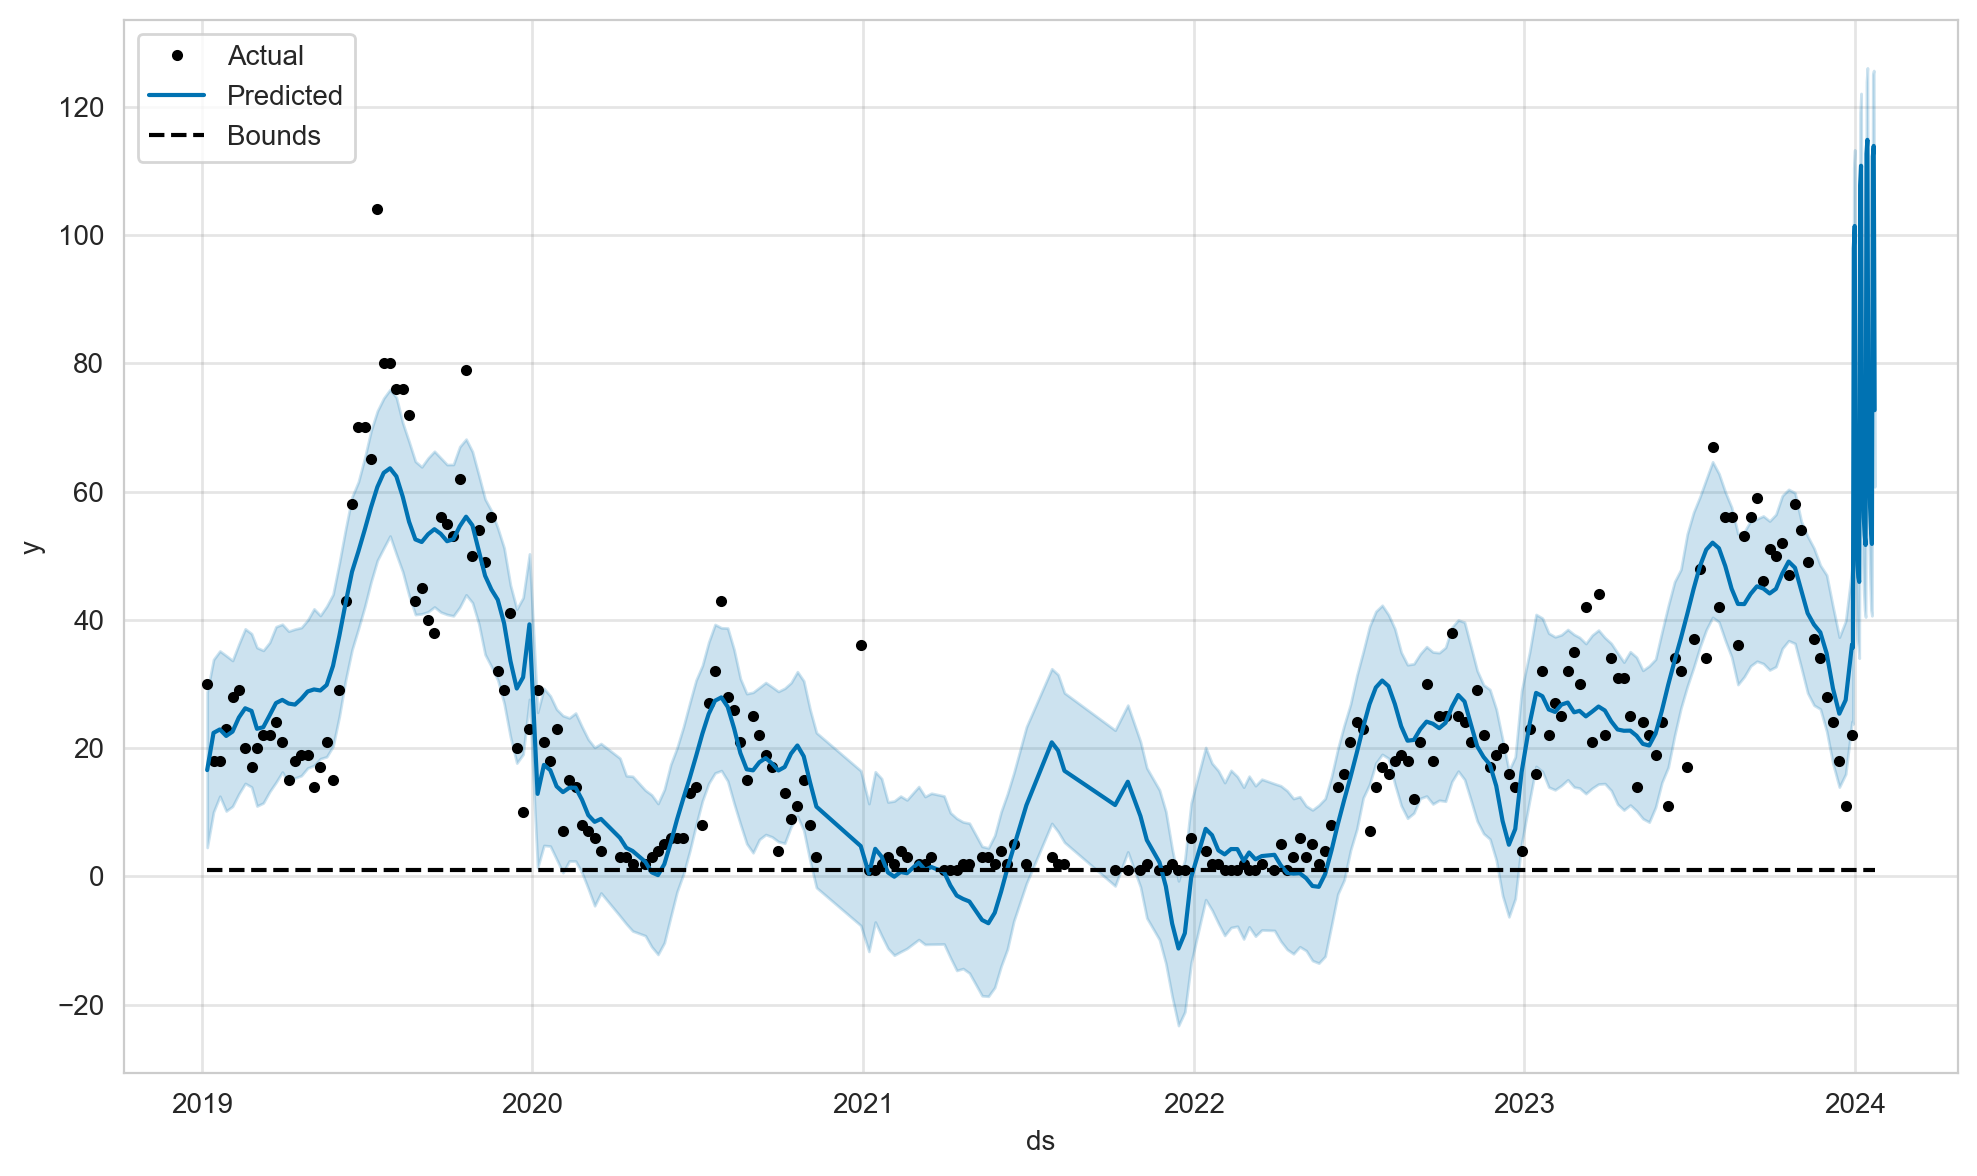

In [185]:

# instantiate the model and fit the timeseries
prophet = Prophet(yearly_seasonality=True, 
                  daily_seasonality=True, 
                  weekly_seasonality=True,
                  growth='linear',
                  n_changepoints= 10,
                  changepoint_range=1, # Consider the whole range for change points
                  changepoint_prior_scale=0.4) # Adjust trend flexibility if it overfits (too large) or underfits (too small).
                                               # Higher value = More flexible trend
prophet.fit(ts)

# Create additional points 25 periods into a future data frame 
future = prophet.make_future_dataframe(periods=25)
future['cap'] = 1
future['floor'] = 0
forecast = prophet.predict(future)

# plot
fig = prophet.plot(forecast)
ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Bounds'])  
pass; 

In [186]:
# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-07,16.570216,4.508201,28.738838
1,2019-01-14,22.370763,10.040352,33.807470
2,2019-01-21,22.910670,12.496904,35.143248
3,2019-01-28,21.896900,10.196083,34.410594
4,2019-02-04,22.569028,10.915661,33.658082


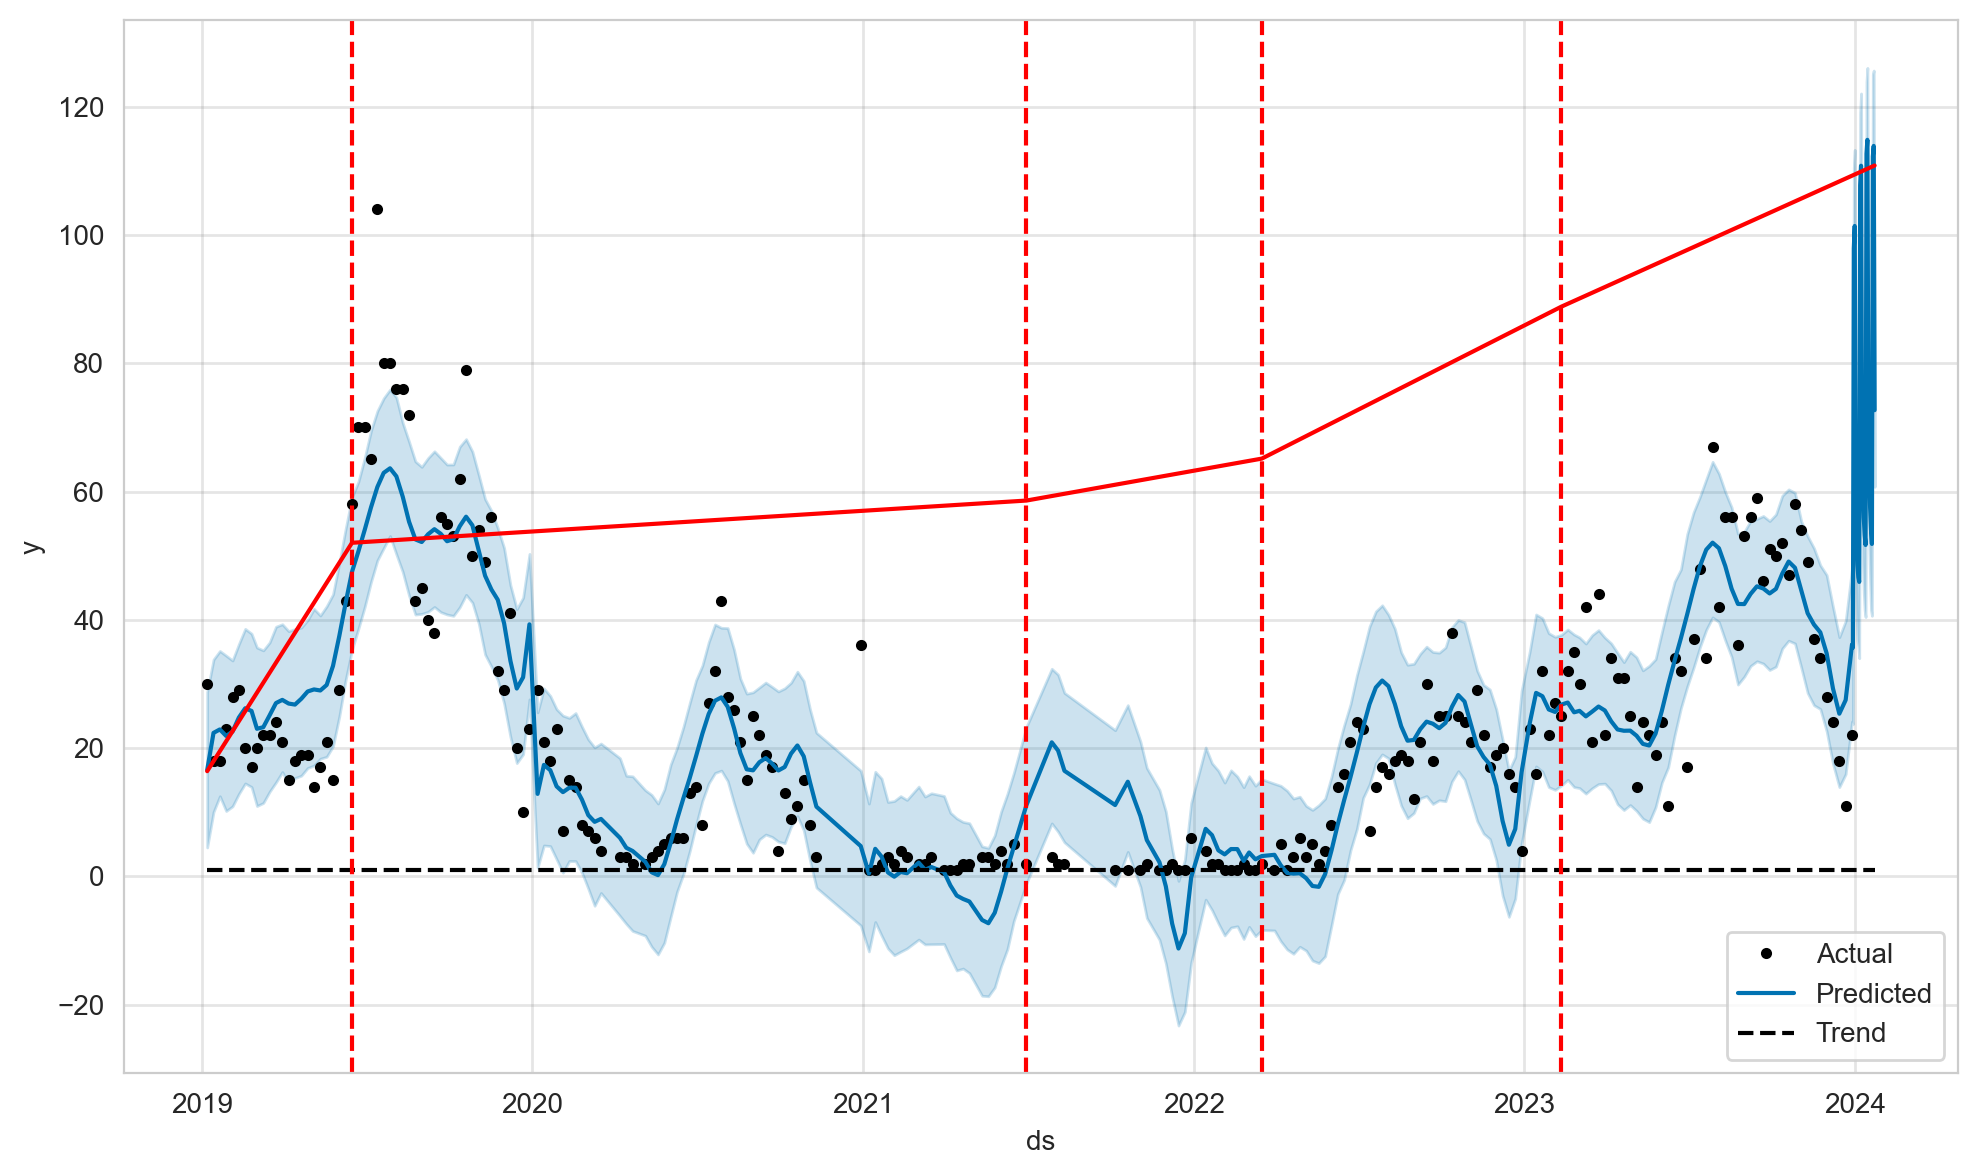

In [187]:
from prophet.plot import add_changepoints_to_plot

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Trend'])  

In [188]:
df.to_csv(r"data\case_all.csv")

In [189]:
from statsmodels.tsa.statespace.varmax import VARMAX

VARMAR

In [190]:
uscon = pd.read_csv('data/case_all.csv',header=0)
uscon.head()

,date,total_case,temp,press,humidity,rain
0,2019-01-07,30,27.282259,1005.820689,85.897126,7.777041
1,2019-01-14,18,27.177412,1005.009584,81.642037,4.164286
2,2019-01-21,18,26.849482,1007.035567,79.545775,0.621429
3,2019-01-28,23,27.270083,1006.782040,83.890311,5.496281
4,2019-02-04,28,27.903425,1008.452154,78.378565,0.078027


In [191]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        232 non-null    object 
 1   total_case  232 non-null    int64  
 2   temp        232 non-null    float64
 3   press       224 non-null    float64
 4   humidity    232 non-null    float64
 5   rain        232 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.0+ KB


In [198]:
uscon[uscon['press'].isna()]

,total_case,temp,press,humidity,rain
date,,,,,
2020-08-04,28,28.394148,NaN,84.909411,4.722024
2020-08-11,26,27.697377,NaN,84.754143,13.490119
2020-08-18,21,27.676182,NaN,85.005877,13.635714
2020-08-25,15,28.406528,NaN,83.723125,7.551786
2020-09-01,25,27.933495,NaN,85.196853,9.850000
2020-09-08,22,27.383191,NaN,84.638083,13.958929
2020-09-15,19,27.455228,NaN,80.404687,11.053571
2020-09-22,17,27.730009,NaN,78.916531,5.954167


In [199]:
# Function to fill missing values with the average of previous and following values
def fill_with_mean(series):
    # Ensure the series is not empty
    if series.empty:
        return series
    
    # Create a copy of the series to avoid modifying the original data
    filled_series = series.copy()
    
    # Iterate over the indices where there are missing values
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):
            # Find the previous and following values
            prev_val = series.iloc[i - 1] if i > 0 else np.nan
            next_val = series.iloc[i + 1] if i < len(series) - 1 else np.nan
            
            # Compute the mean of the previous and next values
            if not pd.isna(prev_val) and not pd.isna(next_val):
                mean_val = (prev_val + next_val) / 2
                filled_series.iloc[i] = mean_val
            elif not pd.isna(prev_val):
                filled_series.iloc[i] = prev_val
            elif not pd.isna(next_val):
                filled_series.iloc[i] = next_val
    
    return filled_series

รัน จนกว่าจะ nan จะหมด

In [209]:
# Apply the function to fill missing values
uscon['press'] = fill_with_mean(uscon['press'])

check nan in press

In [210]:
uscon[uscon['press'].isna()]

,total_case,temp,press,humidity,rain
date,,,,,


In [213]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2019-01-07 to 2023-12-29
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  232 non-null    int64  
 1   temp        232 non-null    float64
 2   press       232 non-null    float64
 3   humidity    232 non-null    float64
 4   rain        232 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 10.9 KB


In [ ]:
# Create pandas time series with date labels correctly shown. 
uscon.date = pd.to_datetime(uscon.date)
uscon.set_index('date',inplace=True)

In [ ]:
# uscon = uscon.resample('W').asfreq()
# uscon.head(50)

### Find best order to fit k_AR_diff

In [214]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(uscon)
print(model.select_order())

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 1, FPE -> 2, HQIC ->  2>


### ADFuller Test

In [215]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is trend stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is stostochastic trend")

In [217]:
for name, column in uscon.items():
    Augmented_Dickey_Fuller_Test_func(uscon[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: total_case
Test Statistic                  -2.956608
p-value                          0.039150
No Lags Used                     5.000000
Number of Observations Used    226.000000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: temp
Test Statistic                  -3.062999
p-value                          0.029415
No Lags Used                     2.000000
Number of Observations Used    229.000000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: press
Test Statistic                  -5.16661
p-value                          0.00001
No Lags Used                     1.00000
Number of Observations Used    230.00000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: humidity
Test Statistic                  -3.168857
p

### Test for Cointegration

In [218]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,0,3)
    traces = res.lr1        # statistical test values
    cvts = res.cvt[:,1]     # critical value at 95% CI
    print('Column Name > Test Stat > C(95%) => Significant')
    print('----------------------------------------------')
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(col, '>', round(trace,2), ">", round(cvt,2), '=>' , trace > cvt)

In [219]:
cointegration_test(uscon)

Column Name > Test Stat > C(95%) => Significant
----------------------------------------------
total_case > 93.78 > 69.82 => True
temp > 56.53 > 47.85 => True
press > 33.45 > 29.8 => True
humidity > 18.33 > 15.49 => True
rain > 6.2 > 3.84 => True


### Split the data set 

In [220]:
split_ratio = 0.7
train_size = int(len(uscon)*split_ratio)
Y_train, Y_test = uscon[:train_size], uscon[train_size:]

In [221]:
uscon

,total_case,temp,press,humidity,rain
date,,,,,
2019-01-07,30,27.282259,1005.820689,85.897126,7.777041
2019-01-14,18,27.177412,1005.009584,81.642037,4.164286
2019-01-21,18,26.849482,1007.035567,79.545775,0.621429
2019-01-28,23,27.270083,1006.782040,83.890311,5.496281
2019-02-04,28,27.903425,1008.452154,78.378565,0.078027
...,...,...,...,...,...
2023-12-01,28,26.863721,1007.435911,89.920629,5.500238
2023-12-08,24,26.813490,1007.187055,89.482885,32.002381
2023-12-15,18,27.116654,1008.151154,88.796577,6.510595


### Grid search VARMA

In [222]:
import itertools

def grid_search_VARMA(Y_train, max_p, max_q):

    results = []

    pq = np.arange(max_p+1), np.arange(max_q+1) 

    for p, q in itertools.product(*pq):
        order = (p, q)
        if order != (0, 0):
            model = VARMAX(Y_train, order=order)
            model_fit = model.fit(disp=False)
            error = model_fit.aicc
            results.append((order, error))
            print(f'VARMAX{order} - AICC:{error}')

    return results

In [223]:
results = grid_search_VARMA(Y_train,3,3)

VARMAX(0, 1) - AICC:4087.8923168174456
VARMAX(0, 2) - AICC:4122.86018053228
VARMAX(0, 3) - AICC:4266.305441041813
VARMAX(1, 0) - AICC:3776.075056059342
VARMAX(1, 1) - AICC:3865.605556820199
VARMAX(1, 2) - AICC:4075.5265908485017
VARMAX(1, 3) - AICC:4503.292213489592
VARMAX(2, 0) - AICC:3827.831596590259
VARMAX(2, 1) - AICC:4040.375658457974
VARMAX(2, 2) - AICC:4516.790315574662
VARMAX(2, 3) - AICC:6472.786043335378
VARMAX(3, 0) - AICC:4005.22475805782
VARMAX(3, 1) - AICC:4485.410396042232
VARMAX(3, 2) - AICC:6470.981473455298
VARMAX(3, 3) - AICC:inf


In [224]:
# Print top 10 best models
print("\nTop 10 best VARMAX configurations:")
for i, (order, error) in enumerate(sorted(results, key=lambda x: x[1])[:10]):
    print(f'{i+1}: VARMAX{order} - AICC:{error}')


Top 10 best VARMAX configurations:
1: VARMAX(1, 0) - AICC:3776.075056059342
2: VARMAX(2, 0) - AICC:3827.831596590259
3: VARMAX(1, 1) - AICC:3865.605556820199
4: VARMAX(3, 0) - AICC:4005.22475805782
5: VARMAX(2, 1) - AICC:4040.375658457974
6: VARMAX(1, 2) - AICC:4075.5265908485017
7: VARMAX(0, 1) - AICC:4087.8923168174456
8: VARMAX(0, 2) - AICC:4122.86018053228
9: VARMAX(0, 3) - AICC:4266.305441041813
10: VARMAX(3, 1) - AICC:4485.410396042232


### Fit best model

best_pq = (2,0) 

In [225]:
best_pq = (1,0)

model = VARMAX(Y_train, order=best_pq, trend='c').fit(disp=False)
model.summary()

Dep. Variable:,"['total_case', 'temp', 'press', 'humidity', 'rain']",No. Observations:,162
Model:,VAR(1),Log Likelihood,-1825.193
,+ intercept,AIC,3740.385
Date:,"Tue, 30 Jul 2024",BIC,3879.327
Time:,02:05:15,HQIC,3796.798
Sample:,0,,
,- 162,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"9.76, 9.95, 1.27, 4.91, 0.39",Jarque-Bera (JB):,"279.27, 10.95, 0.37, 1.79, 322.38"
Prob(Q):,"0.00, 0.00, 0.26, 0.03, 0.53",Prob(JB):,"0.00, 0.00, 0.83, 0.41, 0.00"
Heteroskedasticity (H):,"0.08, 1.85, 1.42, 0.69, 2.08",Skew:,"0.78, -0.42, 0.10, -0.23, 1.53"


In [226]:
model.forecast(4)

,total_case,temp,press,humidity,rain
162,18.279445,28.001911,1004.813869,83.894309,8.218860
163,18.429303,27.972006,1005.071911,83.738606,7.797415
164,18.532757,27.947819,1005.215945,83.615343,7.600372
165,18.609371,27.929338,1005.300362,83.514862,7.470568


In [93]:
from statsmodels.tsa.statespace.varmax import VARMAX
from datetime import datetime

In [227]:
from datetime import timedelta

### Fitted values

<Figure size 1000x400 with 0 Axes>

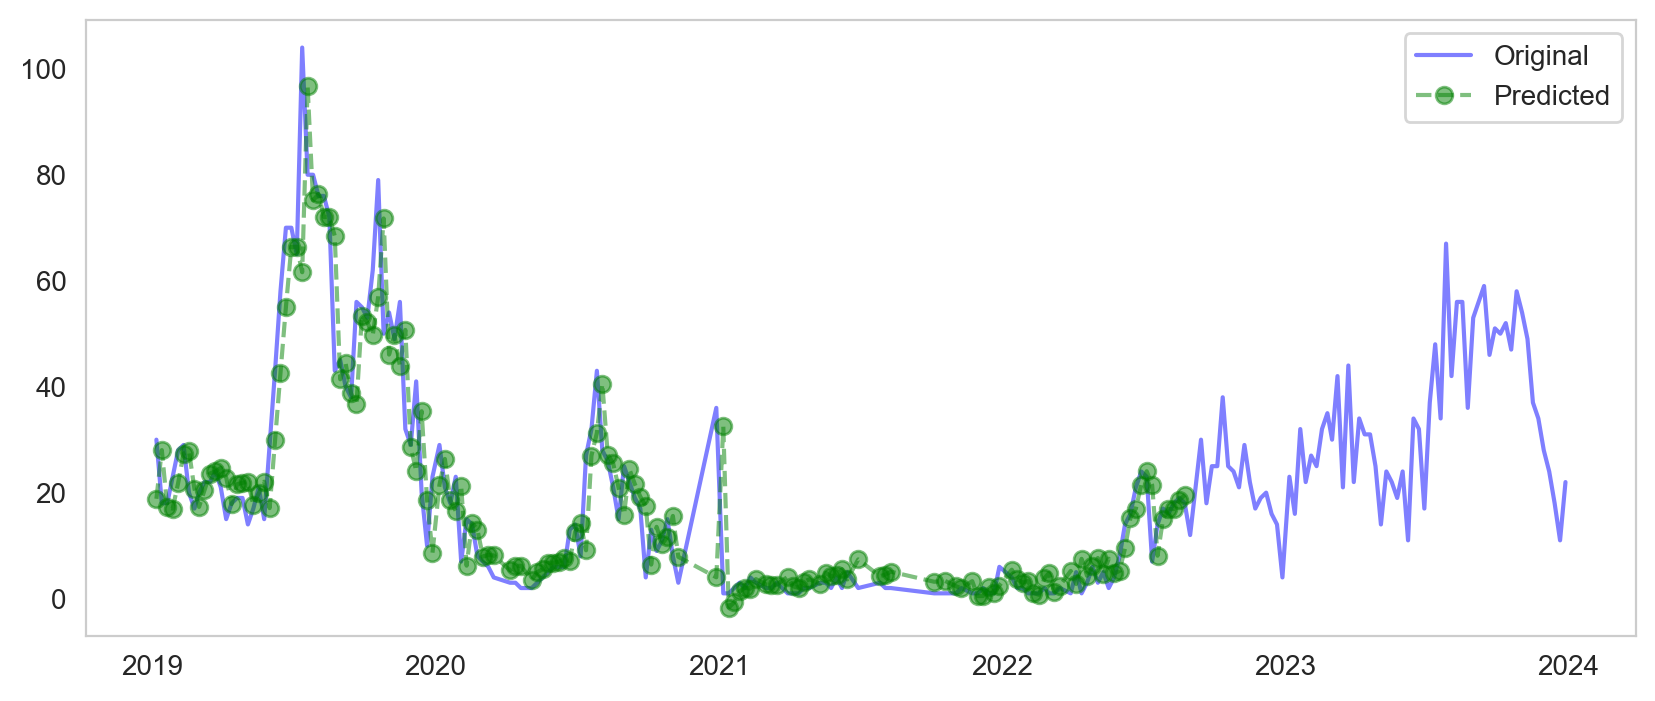

ME: -0.02, RMSE: 8.37, MAPE: 81.67%, WAPE: 27.41%


In [228]:
plt.figure(figsize=(10,4))
plt.plot(uscon['total_case'], alpha=0.5, color='blue', label='Original')
plt.plot(model.predict()['total_case'], marker='o', linestyle='--', alpha=0.5, color='green', label='Predicted')
plt.legend()
plt.show()

get_forecast_accuracy(Y_train['total_case'], model.predict()['total_case'])

MAPE ยิ่งน้อยยิ่งดี , WAPE ยิ่งมากยิ่งแม่น

ME: -0.11, RMSE: 7.90, MAPE: 80.76%, WAPE: 28.45%

In [229]:
history = [y for y in Y_train.values]
train = history
predictions = list()
upper_ci = list()
lower_ci = list()


h = 4
for t in range(len(Y_test)-(h-1)):
      
  model_fit = VARMAX(train, order=best_pq).fit(disp=False)
    
  output = model_fit.get_forecast(h)
  predictions.append(output.predicted_mean[h-1])
  lower_ci.append(output.conf_int()[h-1, 0])
  upper_ci.append(output.conf_int()[h-1, 5])

  history.append(Y_test.iloc[t])
  train = history[t+1:]

<Figure size 800x400 with 0 Axes>

ME: 7.71, RMSE: 14.94, MAPE: 36.69%, WAPE: 35.96%


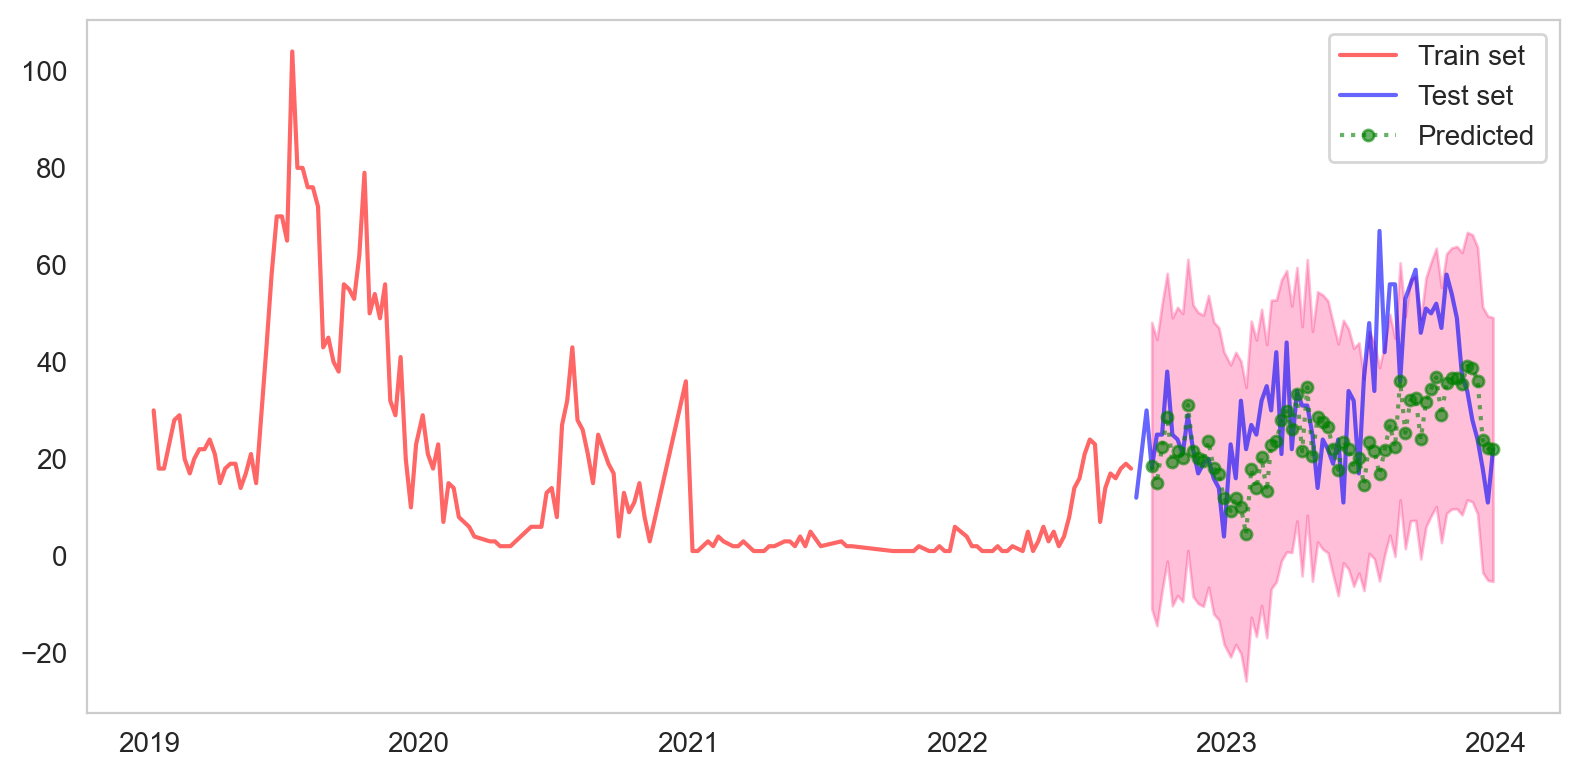

In [230]:
plt.figure(figsize=(8,4))
plt.plot(Y_train['total_case'], label='Train set', color='red', alpha=0.6); 
plt.plot(Y_test['total_case'], label='Test set', color='blue', alpha=0.6); 

predictions_con = pd.Series([i[0] for i in predictions], index=Y_test.index[h-1:])
plt.plot(predictions_con, 'go:', label='Predicted', alpha=0.6, ms=4) 
plt.fill_between(Y_test.index[h-1:], upper_ci, lower_ci, color='#ff0066', alpha=.25)
plt.legend(loc='best')
plt.tight_layout();

get_forecast_accuracy(Y_test['total_case'][h-1:], predictions_con)

ME: 3.23, RMSE: 12.79, MAPE: 38.25%, WAPE: 31.96%

In [79]:
uscon['total_case'].head()

date
2019-01-07    30
2019-01-14    18
2019-01-21    18
2019-01-28    23
2019-02-04    28
Name: total_case, dtype: int64

In [82]:
results = model.forecast(h)
results['total_case'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4 entries, 162 to 165
Series name: total_case
Non-Null Count  Dtype  
--------------  -----  
4 non-null      float64
dtypes: float64(1)
memory usage: 164.0 bytes


In [174]:
Y_test.index[-1]

Timestamp('2023-12-29 00:00:00')

In [231]:

# Define the total number of days to forecast (4 steps of 7 days each)
n_forecast_days = 4 

# Generate the forecast
forecast = model.get_forecast(steps=n_forecast_days)

# Create a date range starting from the day after the last date of the training data for 28 days
last_date = Y_test.index[-1]

# Generate the start date for each step
forecast_dates = [last_date + timedelta(weeks=1 * i) for i in range(n_forecast_days)]
# forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecast_days)

# Convert the forecasted mean to a DataFrame and assign the date range as the index
forecast_mean = forecast.predicted_mean
forecast_mean.index = forecast_dates

# Print the forecast with dates
print(forecast_mean)
forecast_mean.info()

            total_case       temp        press   humidity      rain
2023-12-29   18.279445  28.001911  1004.813869  83.894309  8.218860
2024-01-05   18.429303  27.972006  1005.071911  83.738606  7.797415
2024-01-12   18.532757  27.947819  1005.215945  83.615343  7.600372
2024-01-19   18.609371  27.929338  1005.300362  83.514862  7.470568
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4 entries, 2023-12-29 to 2024-01-19
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  4 non-null      float64
 1   temp        4 non-null      float64
 2   press       4 non-null      float64
 3   humidity    4 non-null      float64
 4   rain        4 non-null      float64
dtypes: float64(5)
memory usage: 192.0 bytes


In [232]:
# Convert 'total_case' column to a Series
total_case_series = forecast_mean['total_case']
total_case_series = forecast_mean.loc[:, 'total_case']
# total_case_series = forecast_mean.loc[:, 'total_case', 'temp']
total_case_series = forecast_mean['total_case']

In [233]:
# Convert Series to DataFrame
total_case_series = total_case_series.reset_index()
total_case_series.columns = ['date', 'total_case']
# Set the 'date' column as the index
total_case_series.set_index('date', inplace=True)
total_case_series

,total_case
date,
2023-12-29,18.279445
2024-01-05,18.429303
2024-01-12,18.532757
2024-01-19,18.609371


In [140]:
uscon

,total_case,temp
date,,
2019-01-07,30,27.282259
2019-01-14,18,27.177412
2019-01-21,18,26.849482
2019-01-28,23,27.270083
2019-02-04,28,27.903425
...,...,...
2023-12-01,28,26.863721
2023-12-08,24,26.813490
2023-12-15,18,27.116654


<Figure size 800x400 with 0 Axes>

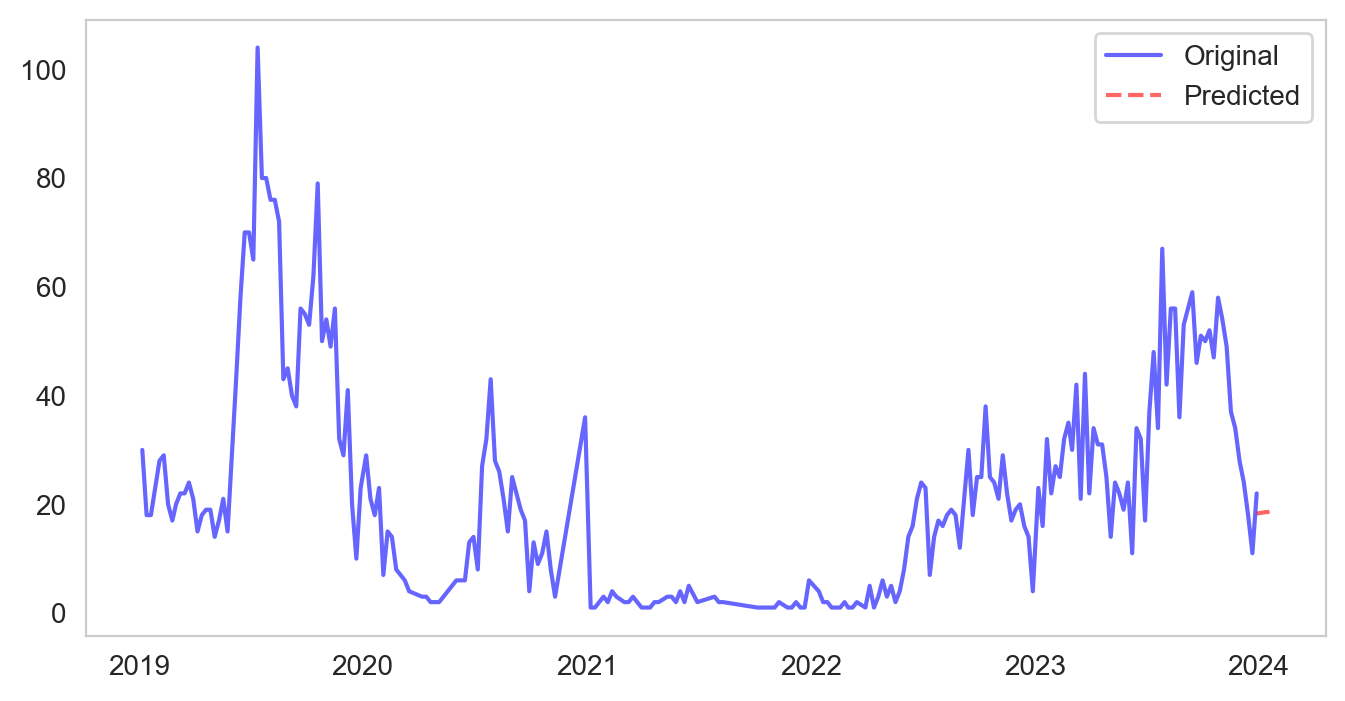

In [234]:
# h = 4

# results = model.forecast(h)

plt.figure(figsize=(8,4))
plt.plot(uscon['total_case'], alpha=0.6, color='blue', label='Original')
plt.plot(total_case_series['total_case'], linestyle='--', alpha=0.6, color='red', label='Predicted')
plt.legend()
plt.show()

<Figure size 2000x400 with 0 Axes>

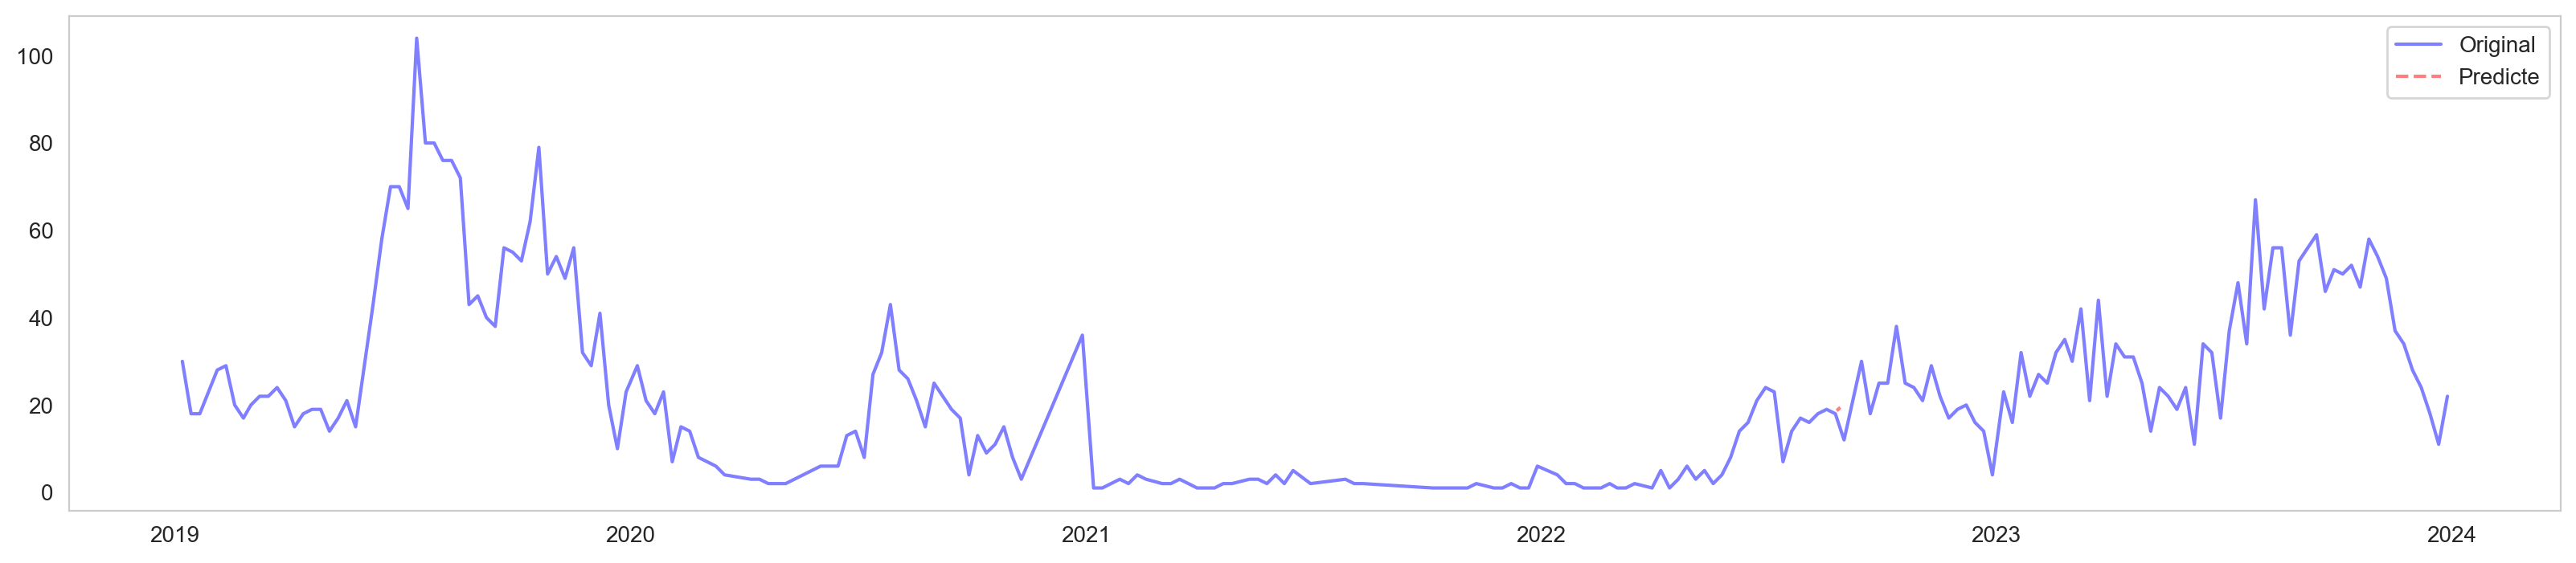

In [114]:
plt.figure(figsize=(20,4))
plt.plot(uscon['total_case'], alpha=0.5, color='blue', label='Original')
plt.plot(results['total_case'], linestyle='--', alpha=0.5, color='red', label='Predicte')
plt.legend()
plt.show()

In [188]:
uscon['total_case'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2019-01-07 to 2023-12-29
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  232 non-null    int64  
 1   temp        232 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.4 KB


In [193]:
results['total_case'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 52 entries, 162 to 213
Series name: total_case
Non-Null Count  Dtype  
--------------  -----  
52 non-null     float64
dtypes: float64(1)
memory usage: 548.0 bytes


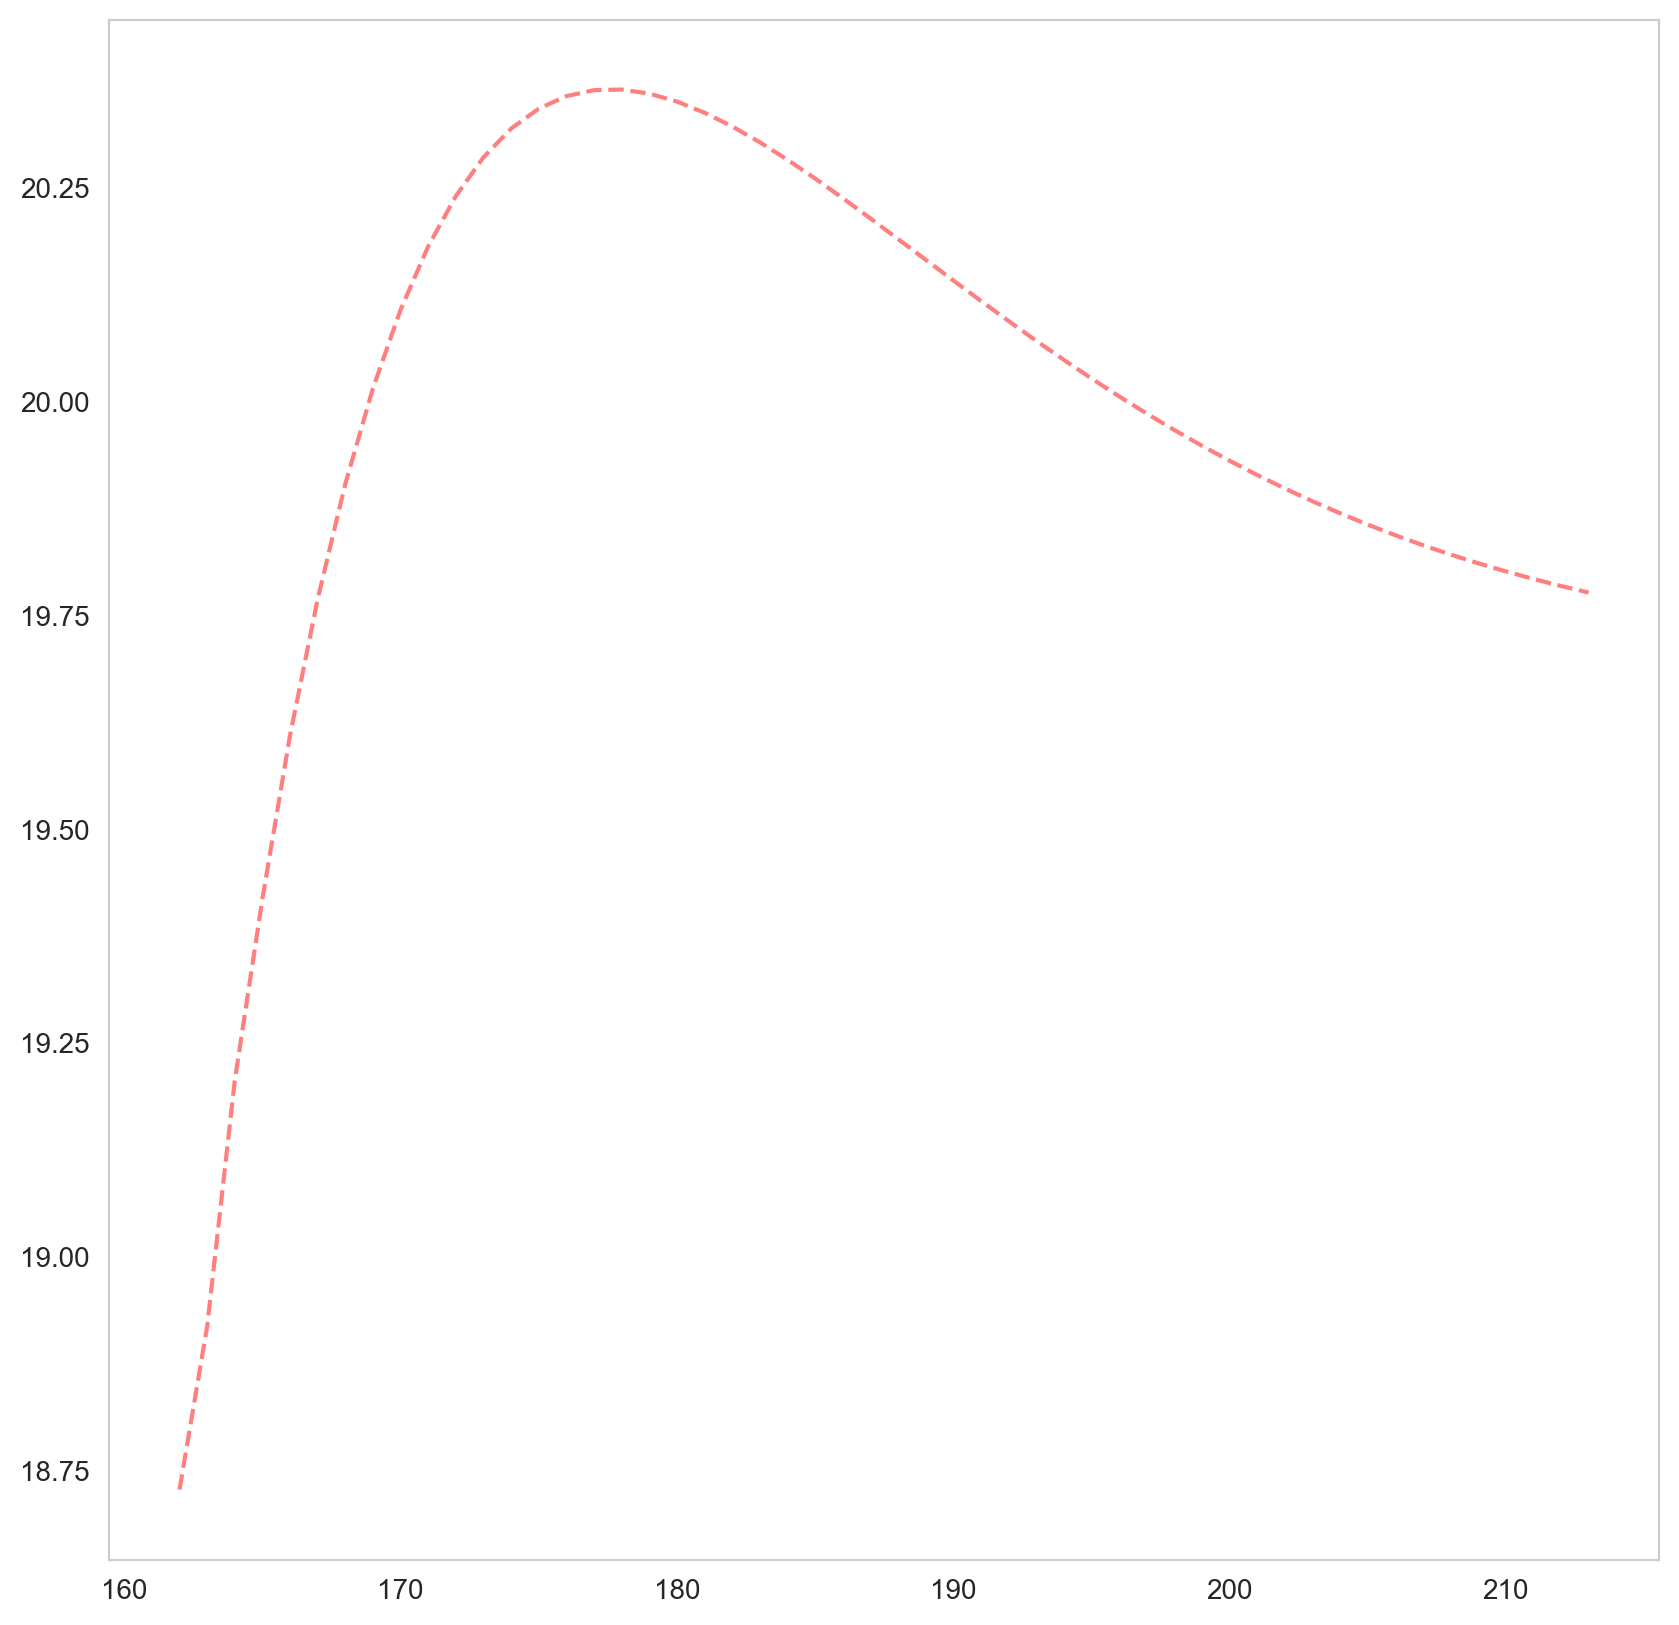

In [180]:
plt.plot(results['total_case'], linestyle='--', alpha=0.5, color='red', label='Predicted')